## CNN Model with Image Augmentation
This is the same as Model #1, but with image augmentation so that the model trains on slightly different images in each epoch

### Imports 

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Setting a random seed for reproducibility
np.random.seed(42)

### Reading in image data as X and y

In [3]:
# specify the path with the subfolders of cleaned eye images (each subfolder is an eye condition)
clean_path = './cleaned_eye_images/'

# the target y is the eye condition 
# make a dictionary of eye conditions and integers because y needs to be a number, not a string
condition_dict = {'normal':0, 'retinopathy': 1, 'glaucoma':2, 'cataracts':3}

# make empty lists for X and y
X=[]
y=[]

# iterate through each subfolder (= condition)
for condition in os.listdir(clean_path):
    
    # make sure the subfolder is actually the name of a condition (e.g., not 'DS_Store')
    if condition in condition_dict.keys():
        
        # iterate through each image file in the subfolder
        for file in os.listdir(clean_path+condition):
            
            # added a try/except so that DS_Store files don't trip an error
            try:
                # load the image file
                image = load_img(clean_path+condition+'/'+file)
                
                # convert the image to an array and normalize it by dividing by 255
                # now normalizing with the ImageGenerator instead
                #image_arr = img_to_array(image) / 255
                
                image_arr = img_to_array(image)
                
                # add the image array to X
                X.append(image_arr)
                
                # use the condition_dict to add the right number to y that corresponds to the eye condition
                y.append(condition_dict[condition])
                
            except:
                continue

In [4]:
# change X and y into numpy arrays
X = np.array(X)
y = np.array(y)

In [5]:
type(X)

numpy.ndarray

In [6]:
# checking the shape of X
# there are 1664 512x512 images with 3 channels (RGB)
X.shape

(1664, 512, 512, 3)

In [7]:
# y matches the number of images in X
y.shape

(1664,)

In [8]:
# y is categorical so we need to one-hot-encode it

# learned about to_categorical here:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

y = to_categorical(y)

### Train-Test Split

In [9]:
# regular train-test-split 
# no need for StandardScaler because the images have already been normalized

# changed test_size to 384 so test and train sizes are both divisible by 64, the batch_size
# to use with image augmentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=384, random_state=42, stratify=y)

In [10]:
X_train.shape

(1280, 512, 512, 3)

### Image Augmentation 

In [11]:
image_generator_train = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, rotation_range=30)

image_generator_test = ImageDataGenerator(rescale=1.0/255.0)

image_generator_train.fit(X_train)

### Building the CNN Model

In [12]:
# Instantiate a Sequential model (that will process each layer sequentially)
model = Sequential()

In [13]:
# add a Convolutional 2D layer that will create 16 3x3 filters to detect image features

# starting with a small number of features and increasing them for each layer is recommended because
# the model finds the smaller number of main features first and then builds them up into more complex larger numbers of features

# the input shape is 512x512 pixels with 3 channels (RGB)
# we chose 512x512 because we wanted smaller files, but didn't want to lose too much data by shrinking them too much
# many of the original image files were much bigger (e.g., 2464×1632, 3GB)
# in the CNN lesson, images were scaled to 256x256, but they weren't medical images, and that seemed too small
# 512x512 is double the size from the lesson
# also, one of the kaggle datasets included preprocessed images which had been resized to 512x512
# we decided to try this image size 

# using relu (rectified linear function) activation, which returns positive output directly and returns 0 for negative output

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(512,512,3)))

In [14]:
# add a MaxPooling 2D layer that will take the maximum value in every 2x2 grid (with a stride defaulting to the pool_size)
# this effectively cuts the dimensions of the data in half, and helps get rid of noise caused by small variations in the image

model.add(MaxPooling2D(pool_size=(2,2)))

In [15]:
# add more convolutional layers (with max pooling between each one) 

# increasing filters to 32
# input shape is only needed for the first layer above
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

# increasing filters to 64
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

In [16]:
# add a flatten layer to bridge between the convolutional layers and the dense layers
model.add(Flatten())

In [17]:
# the dense layer analyzes the features that were identified in the convolutional layers 
model.add(Dense(256, activation='relu'))

model.add(Dense(256, activation='relu'))

In [18]:
# add the output layer
# if there are multiple classes (not binary), change the nodes to the number of classes and use softmax activation
# if it's binary, use sigmoid activation
model.add(Dense(4, activation='softmax'))

In [19]:
# compile the model
# if multiclass, use categorical_crossentropy 
# if binary, use binary_crossentropy
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Fitting the Model

In [20]:
# fit the model and save it as h so the accuracy and loss scores for each epoch can be visualized
# batch size is the number of images processed before updating the metrics
# epochs is the number of times the model goes through the entire dataset

# changing batch size to be divisible by the number of images in X_train
h = model.fit(image_generator_train.flow(X_train, y_train, batch_size=64), validation_data=(image_generator_test.flow(X_test, y_test, batch_size=64)), steps_per_epoch=20, epochs=10)

Epoch 1/10
20/20 [==============================] - 317s 15s/step - loss: 1.3015 - accuracy: 0.4086 - val_loss: 1.0910 - val_accuracy: 0.5286
Epoch 2/10
20/20 [==============================] - 281s 14s/step - loss: 0.9728 - accuracy: 0.5703 - val_loss: 0.9638 - val_accuracy: 0.5703
Epoch 3/10
20/20 [==============================] - 290s 14s/step - loss: 0.7793 - accuracy: 0.6812 - val_loss: 0.8769 - val_accuracy: 0.6484
Epoch 4/10
20/20 [==============================] - 220s 11s/step - loss: 0.7480 - accuracy: 0.6883 - val_loss: 0.6754 - val_accuracy: 0.6849
Epoch 5/10
20/20 [==============================] - 213s 10s/step - loss: 0.6516 - accuracy: 0.7055 - val_loss: 0.7319 - val_accuracy: 0.6901
Epoch 6/10
20/20 [==============================] - 205s 10s/step - loss: 0.6586 - accuracy: 0.7078 - val_loss: 0.6861 - val_accuracy: 0.7109
Epoch 7/10
20/20 [==============================] - 252s 12s/step - loss: 0.6359 - accuracy: 0.7164 - val_loss: 0.7319 - val_accuracy: 0.6797
Epoch 

This model, without any regularization, reaches about 73% validation accuracy before becoming very overfit. We didn't add early stopping, so the final results of this model reflect the last epoch and gave a training accuracy of 82% and a validation accuracy of 72%

### Saving the Model

In [ ]:
# code to save the model as an h5 file so that it can be used in Flask

# however, h5 files are huge, so we're commenting out the code so it doesn't run again by accident
#model.save('model_1.h5')

### Visualizing the accuracy and loss scores for each epoch

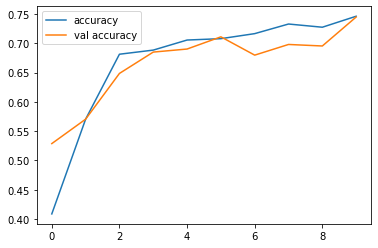

In [21]:
plt.plot(h.history['accuracy'], label='accuracy')
plt.plot(h.history['val_accuracy'], label='val accuracy')
plt.legend();

This plot is similar to the accuracy plot for model 1, which had no image augmentation, but the validation accuracy doesn't diverge as much from the training accuracy. In model 1, it didn't look like additional epochs would be useful because the model was starting to look overfit. Here, it looks like there is more room for the model to learn before it becomes overfit, and it would be good to try increasing the number of epochs. Even though the overall accuracy of this model isn't as good as the accuracy for model 1, it's close, and the fact that it's not overfit is a very good sign.

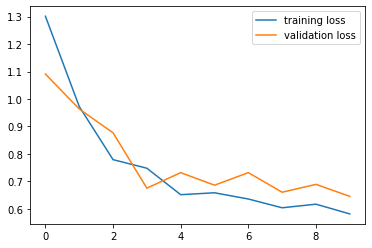

In [22]:
plt.plot(h.history['loss'], label='training loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend();

This plot shows the sharp drop in training loss at epoch one followed by minimal but consistent training loss after that. Validation loss also trends downward, but has a much smaller range. The validation loss diverges slightly from the training loss in the last epoch, but it's not enough to consider the model overfit.

### Generating Predictions

In [23]:
# generate predictions from X_test
preds = model.predict(X_test)

In [24]:
# change the list of prediction probabilities into predictions of a number 0-4 by taking the index of the max probability
simple_preds = []
for prediction in preds:
    simple_preds.append(np.where(prediction == prediction.max())[0][0])

In [25]:
# reverse-one-hot-encode y_test 

# learned about np.argmax here:
# https://stackoverflow.com/questions/54143458/convert-categorical-data-back-to-numbers-using-keras-utils-to-categorical

y_test_simple = np.argmax(y_test, axis=-1)

# make sure it worked
y_test_simple

array([1, 3, 3, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 3, 3, 0, 2, 1, 3, 3,
       3, 3, 1, 3, 3, 3, 1, 0, 0, 3, 1, 3, 3, 2, 2, 2, 2, 3, 2, 1, 1, 0,
       0, 2, 1, 2, 3, 3, 1, 1, 1, 0, 3, 1, 3, 2, 1, 2, 3, 1, 3, 1, 1, 0,
       2, 1, 3, 2, 2, 3, 2, 0, 1, 3, 3, 0, 2, 1, 0, 0, 2, 2, 3, 3, 1, 2,
       1, 1, 2, 1, 1, 0, 2, 0, 0, 3, 1, 1, 2, 2, 3, 1, 1, 0, 1, 0, 2, 1,
       2, 3, 0, 2, 3, 3, 1, 2, 3, 0, 2, 2, 2, 1, 1, 3, 1, 3, 3, 0, 3, 1,
       1, 3, 3, 1, 2, 3, 0, 1, 3, 1, 2, 3, 2, 2, 1, 2, 3, 2, 3, 1, 2, 1,
       0, 1, 2, 1, 1, 1, 3, 0, 2, 2, 2, 0, 3, 1, 1, 3, 0, 3, 1, 0, 3, 1,
       2, 1, 0, 1, 1, 3, 3, 0, 3, 2, 0, 0, 0, 2, 0, 3, 3, 3, 2, 3, 1, 3,
       0, 0, 0, 1, 2, 3, 0, 2, 2, 0, 2, 3, 1, 2, 3, 3, 0, 3, 0, 1, 3, 2,
       3, 2, 0, 3, 3, 1, 2, 3, 3, 0, 1, 2, 2, 3, 2, 2, 2, 0, 2, 1, 2, 2,
       1, 3, 0, 1, 3, 2, 1, 3, 1, 3, 2, 0, 2, 2, 3, 1, 1, 0, 0, 3, 3, 2,
       3, 0, 3, 0, 3, 3, 3, 1, 1, 0, 1, 2, 0, 1, 1, 3, 2, 2, 0, 0, 0, 2,
       3, 3, 2, 0, 0, 3, 2, 2, 2, 0, 0, 0, 3, 1, 1,

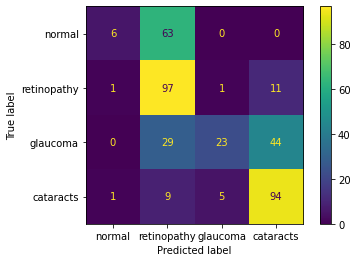

In [26]:
# make and display a confusion matrix
conf_matrix = confusion_matrix(y_test_simple, simple_preds)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=(list(condition_dict.keys()))).plot();

Compared to model 1, this model did better at identifying normal eye images but significantly struggled with distinguishing cataracts from glaucoma. This model also incorrectly labeled images as retinopathy a lot more often than model 1. 

### Adding More Epochs
Running the model through 5 more epochs after the initial 10 above

In [148]:
# seeing if this works

# according to this, you can continue training on the same model as long as you don't re-compile it --
# https://stackoverflow.com/questions/50572884/how-to-increasing-number-of-epoch-in-keras-conv-net

h_more_epochs = model.fit(image_generator_train.flow(X_train, y_train, batch_size=64), validation_data=(image_generator_test.flow(X_test, y_test, batch_size=64)), steps_per_epoch=20, epochs=5)

Epoch 1/5
20/20 [==============================] - 328s 16s/step - loss: 0.5471 - accuracy: 0.7664 - val_loss: 0.6488 - val_accuracy: 0.7109
Epoch 2/5
20/20 [==============================] - 283s 14s/step - loss: 0.5355 - accuracy: 0.7672 - val_loss: 0.7079 - val_accuracy: 0.7083
Epoch 3/5
20/20 [==============================] - 274s 14s/step - loss: 0.5242 - accuracy: 0.7812 - val_loss: 0.6145 - val_accuracy: 0.7500
Epoch 4/5
20/20 [==============================] - 251s 12s/step - loss: 0.5394 - accuracy: 0.7711 - val_loss: 0.6941 - val_accuracy: 0.7031
Epoch 5/5
20/20 [==============================] - 246s 12s/step - loss: 0.5791 - accuracy: 0.7445 - val_loss: 0.6485 - val_accuracy: 0.7109


Adding 5 more epochs led to a maximum training accuracy of 78% and testing accuracy of 75% in epoch 3